## Setup

In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import os
from scipy import signal
from typing import Union, List, Tuple, Dict
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.transform.distribution_transformation import range2norm, range2logn
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD_AXON, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

## Set up configuration

#### Trial configurations

In [2]:
number_cells = 1
number_locs = 20
number_samples = number_cells*number_locs
rand_seed = 12345

inference_list = ['y', 'd', 'theta', 'h', 'phi']  # can use d, theta instead of x, z to represent location
randomized_list = ['alpha']  # randomized parameters not to inferred
randomized_list += inference_list
# parameters not in the two lists above are fixed at default.

#### Simulation configurations

In [3]:
loc_param_list = ['x','y','z','alpha','h','phi']
geo_param_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu','l_d']

loc_param_default = {'x': 0., 'y': 0., 'z': 50., 
                     'alpha': np.pi/4, 'h': 1., 'phi': 0.}
loc_param_default['d'], loc_param_default['theta'] = cart2pol(loc_param_default['x'], loc_param_default['z'])
geo_param_default = {'r_s': 7., 'l_t': 500., 'r_t': .54, 
                     'r_d': .3, 'r_tu': .3, 'l_d': 200., 'r_a': .3}

loc_param_range = {'x': (-50, 50), 'y': (-1400, 1400), 'z': (20., 200.), 
                   'alpha': (0, np.pi), 'h': (-1., 1.) ,'phi': (-np.pi, np.pi), 
                   'd': (20., 200.), 'theta': (-np.pi/3, np.pi/3)}
geo_param_range = {'r_s': (5., 12.), 'l_t': (20., 800.), 'r_t': (.25, .8), 
                   'r_d': (.15, .45), 'r_tu': (.15, .45), 'l_d': (100., 300.), 'r_a': (.15, .45)}

loc_param_dist = {'x': 'unif', 'y': 'unif', 'z': 'unif', 
                     'alpha': 'unif', 'h': 'unif','phi': 'unif', 'd': 'unif', 'theta': 'norm'}
geo_param_dist = {'r_s': 'unif', 'l_t': 'unif', 'r_t': 'unif', 
                     'r_d': 'logn', 'r_tu': 'logn', 'l_d': 'unif', 'r_a': 'logn'}


#### Synapse parameters

In [4]:
# Fixed gmax, not using gmax mapping file
gmax = 0.02

# stimulus parameter
stim_param = {'start': 2.}

#### Fixed biophysical parameters

In [5]:
# Biophysical parameters
model_name = 'neuronal_model_491766131'
filepath = './cell_inference/resources/biophys_parameters/'+model_name+'.json'
f = open(filepath)
full_biophys = json.load(f)
f.close()

# common parameters
biophys_param = [] # (soma,dend,apic,axon)
biophys_comm = {'cm': 3.05}

### Create configuration dictionary

In [6]:
config_dict = { 
    'Trial_Parameters': {'number_cells': number_cells, 'number_locs': number_locs, 
                         'number_samples': number_samples, 'rand_seed': rand_seed, 
                         'inference_list': inference_list, 'randomized_list': randomized_list}, 
    'Simulation_Parameters': {'loc_param_list': loc_param_list, 'geo_param_list': geo_param_list, 
                              'loc_param_default': loc_param_default, 'geo_param_default': geo_param_default, 
                              'loc_param_range': loc_param_range, 'geo_param_range': geo_param_range, 
                              'loc_param_dist': loc_param_dist, 'geo_param_dist': geo_param_dist,
                              'stim_param': stim_param, 'gmax': gmax, 'gmax_mapping': None,
                              'full_biophys': filepath, 'biophys_param': biophys_param, 'biophys_comm': biophys_comm }
}

## Generate random samples

In [7]:
rng = np.random.default_rng(rand_seed)

def generator_dist(p_range: Union[List[float],Tuple[float],np.ndarray], dist_type: str, rng: np.random.Generator):
    if dist_type == 'unif':
        def generator(size=None):
            return rng.uniform(low=p_range[0], high=p_range[1], size=size)
    if dist_type == 'norm':
        mu, sigma = range2norm(p_range[0], p_range[1], n_sigma=3)
        def generator(size=None):
            return rng.normal(loc=mu, scale=sigma, size=size)
    if dist_type == 'logn':
        mu, sigma = range2logn(p_range[0], p_range[1], n_sigma=3)
        def generator(size=None):
            return rng.lognormal(mean=mu, sigma=sigma, size=size)
    return generator

def generate_parameters(num: int, param_keys: List[str], param_default: List[float], 
                        param_range: List[Union[List[float],Tuple[float],np.ndarray]], param_dist: List[str]):
    array_size = num
    param_array = {}
    for key in param_keys:
        if key in randomized_list:
            generator = generator_dist(param_range[key], param_dist[key], rng)
            param_array[key] = generator(size=array_size)
        else:
            param_array[key] = np.full(array_size, param_default[key])
    return param_array

#### Location parameters

In [8]:
loc_param_gen = loc_param_list.copy()
if 'd' in randomized_list and 'theta' in randomized_list:
    loc_param_gen[loc_param_gen.index('x')] = 'd'
    loc_param_gen[loc_param_gen.index('z')] = 'theta'

loc_param_samples = generate_parameters(number_samples, loc_param_gen, loc_param_default, loc_param_range, loc_param_dist)

if 'd' in randomized_list and 'theta' in randomized_list:
    loc_param_samples['x'], loc_param_samples['z'] = pol2cart(loc_param_samples['d'],loc_param_samples['theta'])

loc_param = np.column_stack([loc_param_samples[key] for key in loc_param_list])

# reshape into ncell-by-nloc-by-nparam
loc_param = loc_param.reshape(number_cells,number_locs,-1)

#### Geometery parameters

In [9]:
geo_param_samples = generate_parameters(number_cells, geo_param_list, geo_param_default, geo_param_range, geo_param_dist)

geo_param = np.column_stack([geo_param_samples[key] for key in geo_param_list])

# repeat to match number_samples
for key, value in geo_param_samples.items():
    geo_param_samples[key] = np.repeat(value,number_locs)

### Get parameters to be inferred as labels

In [10]:
samples = {**geo_param_samples, **loc_param_samples}
labels = np.column_stack([ samples[key] for key in inference_list ])
rand_param = np.column_stack([ samples[key] for key in randomized_list[:-len(inference_list)] ])

np.set_printoptions(suppress=True)
print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(1, 20, 6)
(1, 6)
(20, 5)


## Create simulation and run

In [11]:
sim = Simulation(geometry = geo_standard,
                 full_biophys = full_biophys,
                 electrodes = params.ELECTRODE_POSITION,
                 cell_type = CellTypes.ACTIVE_AXON,
                 biophys_comm = biophys_comm,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 spike_threshold = -30,
                 gmax = gmax,
                 stim_param = stim_param,
                 ncell = number_cells)

sim.run_neuron_sim()

## Get LFPs
#### Save what

In [12]:
save_lfp = True
save_stats = True

#### Reshape LFP array. Filter each channel. Get window of spike for each sample.

In [13]:
lfp = sim.get_lfp('all',multiple_position=True)  # (cells x locs x channels x time)
lfp = lfp.reshape((-1,)+lfp.shape[-2:]).transpose((0,2,1))  # -> (samples x channels x time) -> (samples x time x channels)

filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                               params.FILTER_CRITICAL_FREQUENCY,
                               params.BANDFILTER_TYPE,
                               fs=params.FILTER_SAMPLING_RATE)

start_idx = int(np.ceil(stim_param['start']/h.dt)) # ignore signal before
filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=1)[:,start_idx:,:]  # filter along time axis

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
lfp_list = []
for i in tqdm(range(number_samples)):
#     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    start, end = get_spike_window(filtered_lfp[i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[i,start:end,:])

t = sim.t()[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

100%|████████████████████████████████████████| 20/20 [00:00<00:00, 2228.41it/s]


In [14]:
if save_stats:
    y_idx = inference_list.index('y') if 'y' in inference_list else None
    summ_stats = []
    bad_indices = []
    yshift = []
    for i in tqdm(range(number_samples)):
        try:
            g_lfp, _, y_c = build_lfp_grid(windowed_lfp[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
        except ValueError:
            bad_indices.append(i)
            continue
        summ_stats.append(calculate_stats(g_lfp))
        if y_idx is not None:
            yshift.append(y_c - labels[i, y_idx])

    summ_stats = np.array(summ_stats)
    yshift = np.array(yshift)
    print('%d bad samples.' % len(bad_indices))

100%|██████████████████████████████████████████| 20/20 [01:29<00:00,  4.50s/it]

0 bad samples.


## Save configurations and simulation data

In [15]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, model_name+'_Loc5')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats')  # summary statistics
MEM_VOLT_PATH = os.path.join(TRIAL_PATH, 'mem_volt')  # membrane voltage and spike times

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    print("The new data directory is created!")

if not os.path.exists(TRIAL_PATH):
    os.makedirs(TRIAL_PATH)
    print("The new trial directory is created!")

In [16]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, y=labels, rand_param=rand_param, gmax=gmax)
if save_stats:
    np.savez(STATS_PATH, t=t, x=summ_stats, y=np.delete(labels, bad_indices, axis=0),
         rand_param=rand_param, gmax=gmax, ys=yshift, bad_indices=bad_indices)
# np.savez(MEM_VOLT_PATH, v=mem_volt, spk=tspk)
with open(CONFIG_PATH, 'w') as fout:
    json.dump(config_dict, fout, indent=2)

### Verify LFPs
We hand compare the LFP plots generated by our data

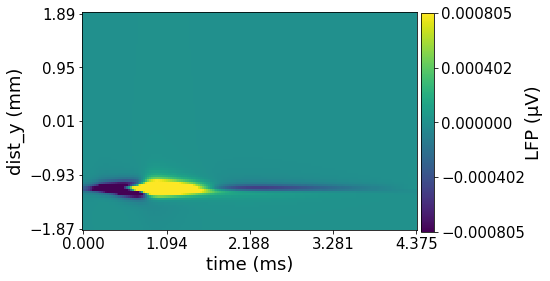

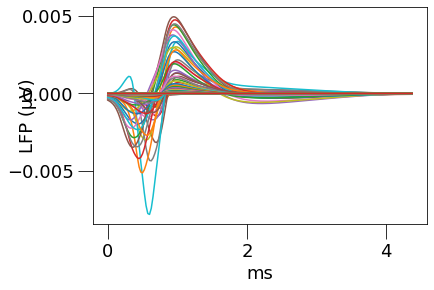

In [17]:
%matplotlib inline

cell_idx = 0

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

_ = plot_lfp_heatmap(t,params.ELECTRODE_POSITION[e_idx, 1],
                              windowed_lfp[cell_idx][:,e_idx], vlim='auto',
                              fontsize=18, labelpad=0, ticksize=15, nbins=5)

_ = plot_lfp_traces(t, windowed_lfp[cell_idx], fontsize=18)